# Matrix factorization using singular value decomposition

## Introduction to the method and math

Singular value decomposition was approach used by Simon Funk to predict user scores for movies given the user's past ratings and ratings of other user for Netflix challenge. He was given higly sparse data that consisted of only 100M ratings out of 8.5B possible entries.

SVD of any matrix M (users × movies) can be written as $$ ( M \approx U \times V^T ) $$ where:
-  U : Matrix representing latent features of users.
- $V^T$ : Matrix representing latent features of movies.

The dimensions of U and $V^T$ are reduced (e.g., 40 features), as users and movies can be described by fewer latent traits, such as genre preferences.

#### Gradient Descent for SVD
1. **Initialization**: Start with random U and  V.
2. **Prediction**: Approximate the (i, j)-th entry as $ M_{ij} = u_i \cdot v_j $ (dot product of corresponding vectors).
3. **Error Calculation**: Compute the difference between predicted and actual values.
4. **Loss Function**: Minimize the Mean Squared Error (MSE) over known entries in M:
   $$
   L = \frac{1}{n} \sum_{(i,j) \in \text{known}} (M_{ij} - u_i \cdot v_j)^2
   $$
5. **Update Rules**:
   Adjust $ u_i $ and $ v_j $ using gradient descent.


Only observed entries in M are used for training. The remaining entries are ignored to reduce computational complexity and focus on known values.

## Applying problem to our Anime Recommendation System

First we need to import crucial modules. We used Surprise library for SVD algorithm since Gradient Descent implementation was already discussed in class

In [1]:
import pandas as pd
import numpy as np
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise import Reader, Dataset

Next we need to load and format the data, getting rid of rows with missing data and unrated anime. Since there is so much data deleting some wont make much of a difference

In [2]:
ratings = "C:/Users/Karolina/Documents/GitHub/machine-learning-project/data/rating.csv"
anime = "C:/Users/Karolina/Documents/GitHub/machine-learning-project/data/anime.csv"

# remove unrated anime
df_ratings = pd.read_csv(ratings, sep=",", names=["user_id" ,"anime_id" ,"rating"], skiprows=1)
df_anime = pd.read_csv(anime, sep=",", names=["anime_id","name", "genre","type","episodes","rating","members"], skiprows=1)

# clean data
df_anime = df_anime.dropna(subset=["genre", "rating"])
df_ratings = df_ratings.dropna(subset=["anime_id", "user_id"])
df_anime = df_anime.dropna(subset=["anime_id"])
watched_anime = df_ratings
df_ratings = df_ratings[df_ratings["rating"] != -1]

# Ensure we only include anime_ids that exist in the anime dataset
valid_anime_ids = set(df_anime["anime_id"].unique())
df_ratings = df_ratings[df_ratings["anime_id"].isin(valid_anime_ids)]
watched_anime = watched_anime[watched_anime["anime_id"].isin(valid_anime_ids)]


reader = Reader(rating_scale=(1,10))
data = Dataset.load_from_df(df_ratings, reader).build_full_trainset()

Next we use Surprise library to train out model

In [3]:
#Train model
svd = SVD(n_factors=100, reg_all=0.05)
svd.fit(data)

print("SVD training completed!")

SVD training completed!


Anime recommendation fucntion definition

In [4]:
def recommend_anime(user_id, model, ratings_df, anime_df, n_recommendations=10):
    """
    Generate anime recommendations for a specific user.

    Parameters:
    -----------
    user_id : int
        The ID of the user to generate recommendations for
    model : SVD
        Trained singular value decomposition model
    ratings_df : pandas.DataFrame
        DataFrame containing ratings metadata
    anime_df : pandas.DataFrame
        DataFrame containing anime metadata
    n_recommendations : int
        Number of recommendations to generate

    Returns:
    --------
    pandas.DataFrame
        DataFrame containing recommended anime with their metadata and scores
    """
    # Get all unique anime IDs
    all_anime_ids = anime_df["anime_id"].unique()

    # Get the anime already watched by the user
    rated_anime_ids = watched_anime[watched_anime["user_id"] == user_id]["anime_id"].unique()

    # Filter out anime already watched by the user
    unrated_anime_ids = [anime_id for anime_id in all_anime_ids if anime_id not in rated_anime_ids]

    # Predict ratings for all unrated anime
    predictions = []
    for anime_id in unrated_anime_ids:
        prediction = model.predict(user_id, anime_id).est
        predictions.append((anime_id, prediction))

    # Sort predictions by estimated rating in descending order
    predictions.sort(key=lambda x: x[1], reverse=True)

    # Get top N recommendations
    top_recommendations = predictions[:n_recommendations]

    # Build a DataFrame for the recommended anime
    recommended_anime_ids = [anime_id for anime_id, _ in top_recommendations]
    recommended_anime = anime_df[anime_df["anime_id"].isin(recommended_anime_ids)].copy()

    # Add predicted scores to the DataFrame
    recommended_anime["predicted_score"] = recommended_anime["anime_id"].map(
        dict(top_recommendations)
    )

    # Sort by predicted score
    recommended_anime = recommended_anime.sort_values(by="predicted_score", ascending=False)

    return recommended_anime.reset_index(drop=True)


Using the model

In [5]:
print("Anime recommendations for user 11:\n" + recommend_anime(11, svd, df_ratings, df_anime, 30).to_string())

Anime recommendations for user 11:
    anime_id                                                       name                                                                         genre   type episodes  rating  members  predicted_score
0        820                                       Ginga Eiyuu Densetsu                                                Drama, Military, Sci-Fi, Space    OVA      110    9.11    80679         9.018752
1      28977                                                   Gintama°                  Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen     TV       51    9.25   114262         8.939772
2       9969                                              Gintama&#039;                  Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen     TV       51    9.16   151266         8.826939
3        918                                                    Gintama                  Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen     TV      201

## Tests

First i checked how the difference between true and predicted ratings changes due to number of anime rated by user

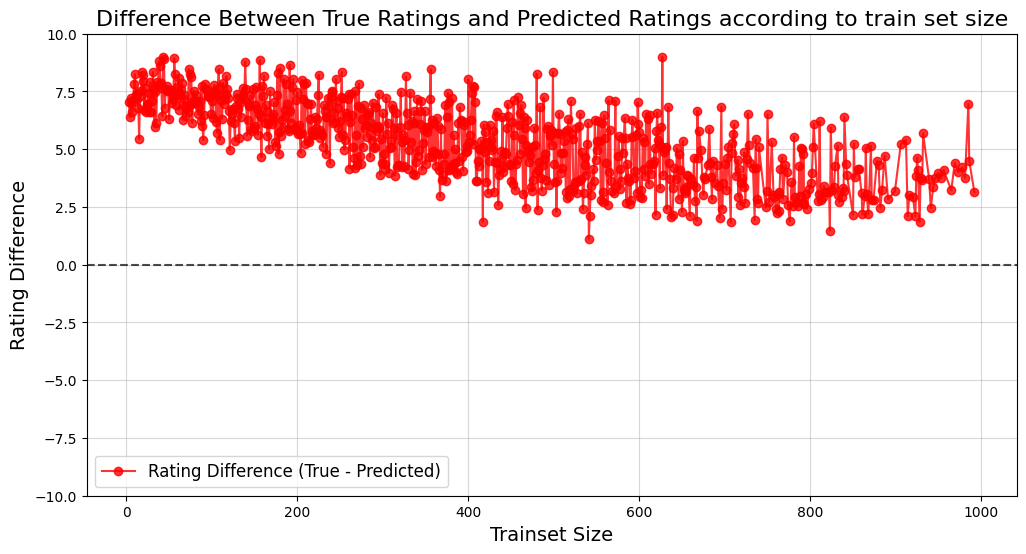

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the predictions.csv file
file_path = "predictions.csv"
predictions_df = pd.read_csv(file_path)

# Ensure the data types are correct
predictions_df["true_rating"] = predictions_df["true_rating"].astype(float)
predictions_df["predicted_rating"] = predictions_df["predicted_rating"].astype(float)

#plot only data with train set size smaller than 1000
predictions_df = predictions_df[predictions_df["train_count"] <= 1000]

# Compute the difference (error) between true and predicted ratings
predictions_df["rating_difference"] = abs(predictions_df["true_rating"] - predictions_df["predicted_rating"])

# Group by train_count to average rating differences
grouped = predictions_df.groupby("train_count")["rating_difference"].max()

# Plot the rating difference
plt.figure(figsize=(12, 6))
plt.plot(grouped.index, grouped, label="Rating Difference (True - Predicted)", marker="o", linestyle="-", alpha=0.8, color="red")

# Add graph details
plt.axhline(0, color="black", linestyle="--", alpha=0.7)  # Add a reference line at 0
plt.title("Difference Between True Ratings and Predicted Ratings according to train set size", fontsize=16)
plt.xlabel("Trainset Size", fontsize=14)
plt.ylabel("Rating Difference", fontsize=14)
plt.ylim(-10, 10)  # Adjust this range based on your data
plt.legend(fontsize=12)
plt.grid(alpha=0.5)

# Show the plot
plt.show()

Mean Squared Error and Mean Absolute Error 

In [7]:
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import cross_validate


ratings = "C:/Users/Karolina/Documents/GitHub/machine-learning-project/data/rating.csv"
anime = "C:/Users/Karolina/Documents/GitHub/machine-learning-project/data/anime.csv"

# remove unrated anime
df_ratings = pd.read_csv(ratings, sep=",", names=["user_id" ,"anime_id" ,"rating"], skiprows=1)
df_anime = pd.read_csv(anime, sep=",", names=["anime_id","name", "genre","type","episodes","rating","members"], skiprows=1)

# clean data
df_anime = df_anime.dropna(subset=["genre", "rating"])
df_ratings = df_ratings.dropna(subset=["anime_id", "user_id"])
df_anime = df_anime.dropna(subset=["anime_id"])
watched_anime = df_ratings
df_ratings = df_ratings[df_ratings["rating"] != -1]

# Ensure we only include anime_ids that exist in the anime dataset
valid_anime_ids = set(df_anime["anime_id"].unique())
df_ratings = df_ratings[df_ratings["anime_id"].isin(valid_anime_ids)]
watched_anime = watched_anime[watched_anime["anime_id"].isin(valid_anime_ids)]


reader = Reader(rating_scale=(1,10))
data = Dataset.load_from_df(df_ratings, reader)
# Run 5-fold cross-validation
cross_validate(svd, data, measures=["RMSE", "MAE"], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1190  1.1209  1.1208  1.1213  1.1198  1.1204  0.0008  
MAE (testset)     0.8383  0.8394  0.8399  0.8403  0.8390  0.8394  0.0007  
Fit time          61.45   64.58   62.94   66.33   62.71   63.60   1.69    
Test time         13.94   11.09   13.47   14.33   11.62   12.89   1.29    


{'test_rmse': array([1.11898671, 1.12088775, 1.12077363, 1.12133003, 1.11980344]),
 'test_mae': array([0.83833697, 0.83938319, 0.83993367, 0.84033545, 0.83896659]),
 'fit_time': (61.44892930984497,
  64.57629776000977,
  62.93602895736694,
  66.32626509666443,
  62.70692467689514),
 'test_time': (13.9445960521698,
  11.09372615814209,
  13.469178199768066,
  14.330637693405151,
  11.615986108779907)}